**Code Flow**

1.   Use CK+ database with expression label and AU labels - *#309 images*
2.   Process the images to obtain frontal and uniform eye distance faces - *using facemask for test*
3.   Scale the obtained images to agreed resolution without distorting aspect-ratio

---

Alternating Optimization 

4.   Use Expression-AU relationship table#2 to initialize missing AU labels as 1 or 0
5.   Extract features and textures from processed images using local binary pattern - *sklearn module*
6.   Reduce dimensionality of the data using PCA/LDA/Adaboost/Gentleboost - *planned in next iteration*
7.   Train SVM classifier with RBF kernel per Eq#21 - *L-BGFS planned in next iteration*
8.   After converging step#7, fix W using optimized values
9.   Start training again using Eq#22
10.   Find best AU config for each sample by Eq#20
11.   If Eq#20 minimized then replace AU config else don't
12.   Repeat step9-11 until all samples are best per Eq#20
13.   Repeat from step#7



In [1]:
def download_dataset_to_collab(dataset):
  '''
  Google Drive is a tag-based (also called semantic) file system, which, for example, allows a file to be in several places at the same time 
  (just by adding IDs of folders to the file's parents property)
  Hence to get the file/folder ID, navigate to the folder using browser & note the ID from URL 
  Ex: https://drive.google.com/drive/folders/1mZVxppM8dHFcoKdc9Vu9vS-n_GGnpCkO
  '''
  #Code to download files from google drive to collab using Pydrive

  !pip install -U -q PyDrive

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  import time

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Auto-iterate through all files in the folder ID.
  start = time.time()
  for key, value in dataset.items():
    print("Initiating files copy from {} ...".format(key))
    if('dir' in key):
      file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(value)}).GetList()      #file_list = drive.ListFile({'q': "'1czmCOb4w0LiWetvQyhIxi6gGvJuAYb5F' in parents and trashed=false"}).GetList()
      for file1 in file_list:      
        file6 = drive.CreateFile({'id': file1['id']}) # Initialize GoogleDriveFile instance with file id.
        file6.GetContentFile(file1['title'])          # Download file as file1['title']
    else:
        fileId = drive.CreateFile({'id': value})
        print(type(value))
        print(fileId)
        print('title: %s, mimeType: %s' % (fileId['title'], fileId['mimeType']))
        fileId.GetContentFile(fileId['title'])
    print("Completed files copy from {}.".format(key))

  end = time.time()                                                                
  return 'time taken:'+ str(end-start) +'seconds'

dataset = {
          #'<file/folder_name>':'<gdrive_folder_id>'
          'dir1':'1p7acuIviEzK5D1-udAdConjhmF7hFJIm',
          'file1':'1PpeI6Rly8NaSMjHbnrP259sWo0Xzxt1J'
          }
download_dataset_to_collab(dataset)

Initiating files copy from dir1 ...
Completed files copy from dir1.
Initiating files copy from file1 ...
<class 'str'>
GoogleDriveFile({'id': '1PpeI6Rly8NaSMjHbnrP259sWo0Xzxt1J'})
title: au4_svm.csv, mimeType: text/csv
Completed files copy from file1.


'time taken:180.58999252319336seconds'

In [19]:
!pwd
!ls -l
!ls datalab/img | wc -l
# !mkdir -p datalab/img
# !mv *.png datalab/img
import os
import numpy as np
#http://scikit-image.org/docs/dev/api/skimage.io.html
from skimage.io import imread
for f in os.listdir('./datalab/img'):
  opath='./datalab/img/'+str(f)
  img = np.asarray(imread(opath))/255.0
print(f, img.shape)
print(np.asarray(imread('/content/datalab/img/S116_007_00000017.png')).shape)

/content
total 20
-rw-r--r-- 1 root root 2495 Aug 28 15:36 adc.json
-rw-r--r-- 1 root root 6490 Aug 28 15:39 au4_svm.csv
drwxr-xr-x 3 root root 4096 Aug 28 15:41 datalab
drwxr-xr-x 2 root root 4096 Aug 24 16:46 sample_data
309
S081_008_00000011.png (382, 500)
(382, 500)


In [0]:
#http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean
from skimage.transform import resize, pyramid_reduce
from skimage.io import imread, imsave
import numpy as np

#https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def scale_img_to_sqaure(img_abs_path, square_size):

  image = np.asarray(imread(img_abs_path))/255.0
  file_name = img_abs_path.split('/')[-1]

  height, width = image.shape    
  if(height > width):
    differ = height
  else:
    differ = width
  differ += 4

  # square filler
  mask = np.zeros((differ, differ), dtype = "float64")

  x_pos = int((differ - width) / 2.0)
  y_pos = int((differ - height) / 2.0)

  # center image inside the square
  mask[y_pos: y_pos + height, x_pos: x_pos + width] = image[0: height, 0: width]

  # downscale if needed
  if differ / square_size > 1:
    mask = pyramid_reduce(mask, differ / square_size)
  else:
    mask = cv2.resize(mask, (square_size, square_size), interpolation = cv2.INTER_AREA)
  imsave(file_name,mask)
  return mask  

# sq = scale_img_to_sqaure('/content/datalab/img/S052_004_00000033.png',96)

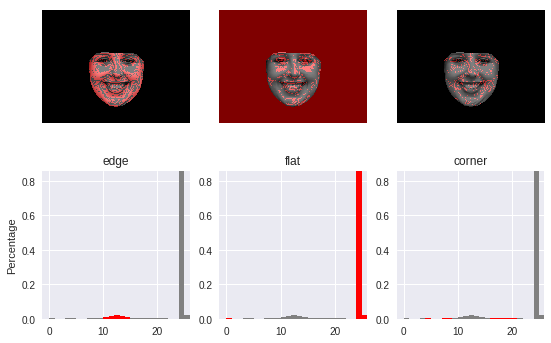

In [28]:
#https://www.bytefish.de/blog/local_binary_patterns/
#http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
import numpy as np
import matplotlib.pyplot as plt


METHOD = 'uniform'
plt.rcParams['font.size'] = 9

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


image = data.load('/content/datalab/img/S052_004_00000033.png')
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(ymax=np.max(counts[:-1]))
    ax.set_xlim(xmax=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


(309, 128, 128)
(309,)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


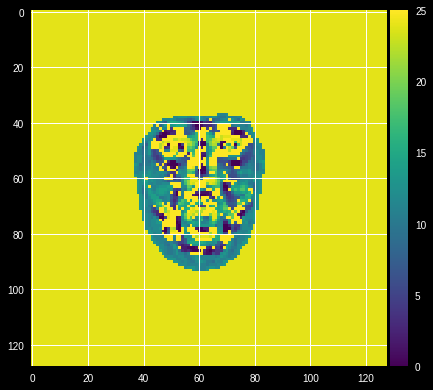

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.45      0.88      0.60        17
        1.0       0.60      0.14      0.23        21

avg / total       0.53      0.47      0.40        38


Confusion matrix:
[[15  2]
 [18  3]]


In [75]:
import os
import csv 
from skimage import data
import numpy as np
from skimage.io import imsave, imshow
from matplotlib import pyplot as plt
from sklearn import svm, metrics

def get_au_label(csvfile, imgfile):
  
  with open(csvfile, 'r') as f:
    r = csv.reader(f, delimiter=' ', quotechar='|')
    for row in r:
      if imgfile in row[0]:
        #print ', '.join(row)
        name,value=row[0].split(',')
        return int(value)
      
def get_lbp(img_path):

  # settings for LBP
  radius = 3
  n_points = 8 * radius
  METHOD = 'uniform'

  image = data.load(img_path)
  return local_binary_pattern(image, n_points, radius, METHOD)

def img_to_vector(path):
  
  X_train = np.ndarray(shape=(len(os.listdir(path)), 128, 128), dtype=np.float64)
  Y_train = np.ndarray(shape=len(os.listdir(path)),dtype=np.float16)
  i=0
  for img in os.listdir(path):
    s,t = img.split('.')  
  #   print(img,get_au_label('au4_svm.csv',s))
    Y_train[i] = get_au_label('au4_svm.csv',s)
    sq_img = scale_img_to_sqaure(path+str(img), 128)
    X_train[i] = get_lbp('/content/'+str(img))
    i += 1
  return X_train,Y_train

def train_svc(X, y, x_test):
  
#   X = [[0, 0], [1, 1]]
#   y = [0, 1]
  clf = svm.SVC()
  clf.fit(X, y)  
#   http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
  svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf', max_iter=-1, probability=False, 
      random_state=None, shrinking=True, tol=0.001, verbose=False)
  return clf

X_train, Y_train = img_to_vector("/content/datalab/img/")
print(X_train.shape)
print(Y_train.shape)
a = imshow(X_train[301])
plt.show(a)

#Flatten the image vectors for SVM classifier 
# - https://stackoverflow.com/questions/33162871/python-scikit-learn-svm-classifier-valueerror-found-array-with-dim-3-expected/35005672
# - https://www.kaggle.com/halien/simple-image-classifer-with-svm
X = X_train[0:270,:,:].reshape(270,-1)
y = Y_train[0:270,]
x_test = X_train[271:,:,:].reshape(38,-1)

classifier = train_svc(X, y, x_test)
y_pred = classifier.predict(x_test)
y_test = Y_train[271:,]

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))